# Import Library

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import random


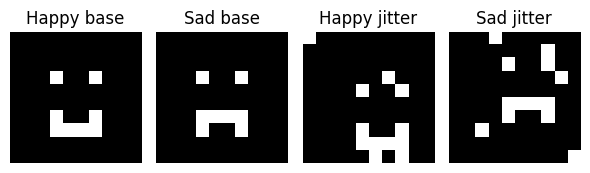

In [11]:
def make_base_emoji(happy=True, size=10):
    """Return a 10x10 numpy array with a simple happy or sad face (0/1 pixels)."""
    img = np.zeros((size, size), dtype=np.float32)

    # Eyes
    img[3, 3] = 1
    img[3, 6] = 1

    # Mouth (arc): happy is U-shape; sad is n-shape
    mouth_y = 7
    if happy:
        # Happy: lower middle pixels
        for x in [3,4,5,6]:
            img[mouth_y, x] = 1
        img[mouth_y-1, 3] = 1
        img[mouth_y-1, 6] = 1
    else:
        # Sad: higher middle pixels
        for x in [3,4,5,6]:
            img[mouth_y-1, x] = 1
        img[mouth_y, 3] = 1
        img[mouth_y, 6] = 1

    return img

def jitter(img, max_shift=1, noise_prob=0.02):
    # Mix it up to try and throw off the AI
    out = img.copy()
    # shift
    dy = random.randint(-max_shift, max_shift)
    dx = random.randint(-max_shift, max_shift)
    out = np.roll(out, shift=dy, axis=0)
    out = np.roll(out, shift=dx, axis=1)
    # add tiny noise
    flip_mask = np.random.rand(*out.shape) < noise_prob
    out = np.clip(out + flip_mask.astype(np.float32), 0, 1)
    return out

# Quick visual sanity check
fig, axs = plt.subplots(1, 4, figsize=(6,2))
samples = [make_base_emoji(True), make_base_emoji(False)]
samples += [jitter(samples[0]), jitter(samples[1])]
titles = ["Happy base", "Sad base", "Happy jitter", "Sad jitter"]
for ax, im, t in zip(axs, samples, titles):
    ax.imshow(im, cmap='gray', vmin=0, vmax=1)
    ax.set_title(t); ax.axis('off')
plt.tight_layout(); plt.show()


# Build own dataset

Train: (1600, 10, 10) (1600,) Test: (400, 10, 10) (400,)


/tmp/ipykernel_6015/3538411071.py:30: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_6015/3538411071.py:30: UserWarning: Glyph 128577 (\N{SLIGHTLY FROWNING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/home/cliff/Documents/Sync/ChampsRobotics_Laptop/.venv/lib64/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cliff/Documents/Sync/ChampsRobotics_Laptop/.venv/lib64/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128577 (\N{SLIGHTLY FROWNING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


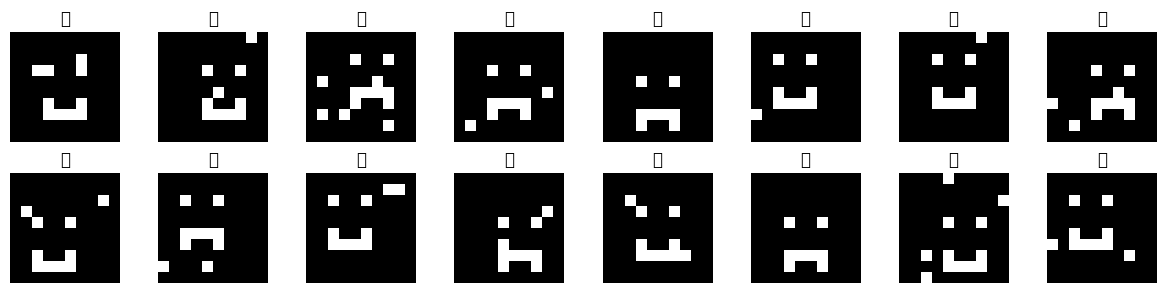

In [12]:
def build_dataset(n_happy=1000, n_sad=1000):
    X, y = [], []
    for _ in range(n_happy):
        X.append(jitter(make_base_emoji(True)))
        y.append(1)  # 1 = happy
    for _ in range(n_sad):
        X.append(jitter(make_base_emoji(False)))
        y.append(0)  # 0 = sad
    X = np.stack(X)                        # (N, 10, 10)
    y = np.array(y, dtype=np.int64)       # (N,)
    # Shuffle
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

X, y = build_dataset(800, 800)   # 1600 samples
X_test, y_test = build_dataset(200, 200)

print("Train:", X.shape, y.shape, "Test:", X_test.shape, y_test.shape)

# Peek at a few samples
def show_grid(X, y, n=8):
    cols = n
    rows = 2
    fig, axs = plt.subplots(rows, cols, figsize=(1.5*cols, 3))
    for i in range(rows*cols):
        r, c = divmod(i, cols)
        axs[r, c].imshow(X[i], cmap='gray', vmin=0, vmax=1)
        axs[r, c].set_title("🙂" if y[i]==1 else "🙁")
        axs[r, c].axis('off')
    plt.tight_layout(); plt.show()

show_grid(X, y, n=8)


# Load into Pytorch

In [13]:
# Flatten 10x10 to 100-dim vectors for an MLP
X_t = torch.tensor(X).view(len(X), -1)
y_t = torch.tensor(y)
X_test_t = torch.tensor(X_test).view(len(X_test), -1)
y_test_t = torch.tensor(y_test)

train_ds = TensorDataset(X_t, y_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)


# Create the Neural Network

In [14]:
class EmojiMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # 2 classes: sad(0), happy(1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmojiMLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

Epoch 01 | loss=0.6792 | test acc=80.8%
Epoch 02 | loss=0.6202 | test acc=85.0%
Epoch 03 | loss=0.4776 | test acc=89.8%
Epoch 04 | loss=0.2692 | test acc=99.0%
Epoch 05 | loss=0.1105 | test acc=99.5%
Epoch 06 | loss=0.0445 | test acc=100.0%
Epoch 07 | loss=0.0227 | test acc=100.0%
Epoch 08 | loss=0.0137 | test acc=100.0%
Epoch 09 | loss=0.0096 | test acc=100.0%
Epoch 10 | loss=0.0071 | test acc=100.0%
Epoch 11 | loss=0.0055 | test acc=100.0%
Epoch 12 | loss=0.0043 | test acc=100.0%


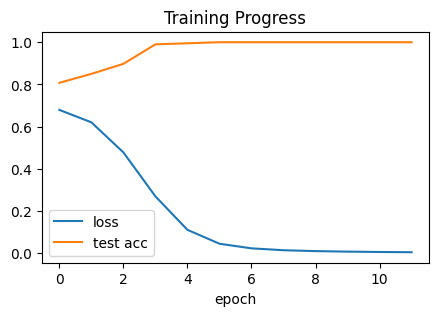

In [ ]:
def train_epoch(model, loader):
    model.train()
    total_loss, total = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
        total += xb.size(0)
    return total_loss / total

def eval_acc(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

EPOCHS = 12
train_hist = []
for epoch in range(1, EPOCHS+1):
    loss = train_epoch(model, train_loader)
    acc  = eval_acc(model, test_loader)
    train_hist.append((loss, acc))
    print(f"Epoch {epoch:02d} | loss={loss:.4f} | test acc={acc*100:.1f}%")

# Save model
torch.save({
    "model_state": model.state_dict(),
    "input_dim": 100,   # 10x10 flattened
    "num_classes": 2
}, "emoji_mlp.pth")

# Plot training progress (optional)
plt.figure(figsize=(5,3))
plt.plot([l for l,a in train_hist], label="loss")
plt.plot([a for l,a in train_hist], label="test acc")
plt.legend(); plt.xlabel("epoch"); plt.title("Training Progress")
plt.show()


# Custom Hand Drawing

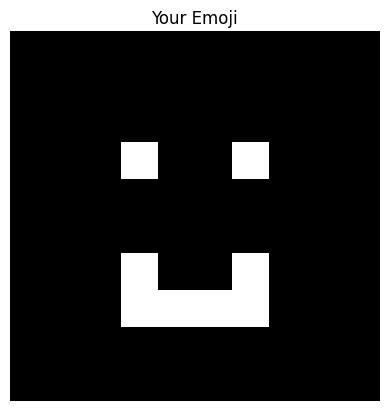

Model says: 🙂 (confidence 1.00)


In [16]:
def draw_custom(pts_on=None, size=10):
    """Create a blank grid, turn on pixels in pts_on=[(y,x), ...]."""
    img = np.zeros((size, size), dtype=np.float32)
    if pts_on:
        for (r,c) in pts_on:
            if 0 <= r < size and 0 <= c < size:
                img[r,c] = 1
    return img

def predict_emoji(img10):
    """img10: 10x10 numpy array of 0/1; returns '🙂' or '🙁' and confidence."""
    with torch.no_grad():
        x = torch.tensor(img10, dtype=torch.float32).view(1,-1).to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    label = "🙂" if np.argmax(probs)==1 else "🙁"
    conf = probs[np.argmax(probs)]
    return label, float(conf)

# Example: student draws a happy with lower arc
custom = np.zeros((10,10), dtype=np.float32)
# eyes
custom[3,3] = 1; custom[3,6] = 1
# mouth (U)
for x in [3,4,5,6]:
    custom[7, x] = 1
custom[6,3] = 1; custom[6,6] = 1

plt.imshow(custom, cmap='gray', vmin=0, vmax=1); plt.axis('off'); plt.title("Your Emoji")
plt.show()

label, conf = predict_emoji(custom)
print("Model says:", label, f"(confidence {conf:.2f})")
